In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from mosestokenizer import *

from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import Tensor, keras
import tensorflow_hub as hub
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Layer
from tensorflow.keras.layers import Embedding, Input, GlobalAveragePooling1D, Dense, TextVectorization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
import keras_tuner

import warnings
warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

# nltk.download('maxent_ne_chunker')
# nltk.download('words')
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

2024-04-13 11:26:01.897755: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-13 11:26:01.935990: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-13 11:26:02.587698: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
df = pd.read_csv('../preprocessed_text/unprocessed_train.csv').sample(frac=1)
df_test = pd.read_csv('../preprocessed_text/unprocessed_test.csv')

X_train_text = df['Text']
X_test_text = df_test['Text']
y_train_categories = df['Verdict']
y_test_categories = df_test['Verdict']

# Data Analysis

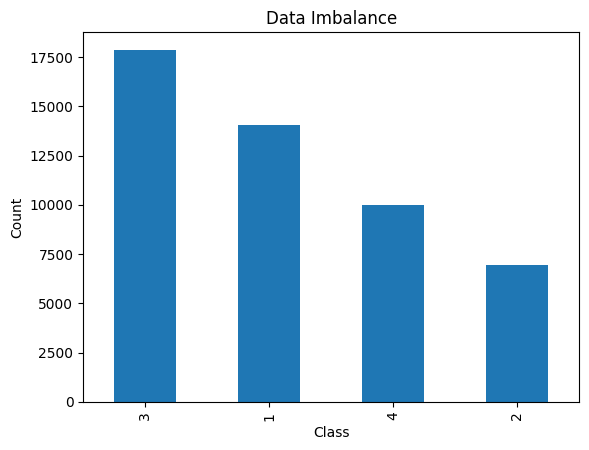

In [4]:
# Count the occurrences of each unique value in y_train
value_counts = y_train_categories.value_counts()

# Plot the data imbalance in a bar chart
value_counts.plot(kind='bar')

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Data Imbalance')

# Display the bar chart
plt.show()

In [5]:
df.head()

,Verdict,Text,Preprocessed Text
3178,1,In an emotional public address this morning ah...,In an emotional public address this morning ah...
47944,4,Smartphones loaded with 'Guitar Hero' have eme...,Smartphones loaded with 'Guitar Hero' have eme...
47282,4,The African Union (AU) will hold its 13th summ...,The African Union (AU) will hold its 13th summ...
1411,1,Mere seconds after a hotly contested rebound d...,Mere seconds after a hotly contested rebound d...
6346,1,Forty-one-year-old printer repairman and husba...,Forty-one-year-old printer repairman and husba...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48854 entries, 3178 to 17166
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Verdict            48854 non-null  int64 
 1   Text               48854 non-null  object
 2   Preprocessed Text  48854 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


# Preprocess text

In [7]:
def lowercase(text: Tensor) -> Tensor:
  return tf.strings.lower(text)

def remove_numbers(text: Tensor) -> Tensor:
  return tf.strings.regex_replace(text, '[0-9]', '')

def remove_punctuations(text: Tensor) -> Tensor:
  return tf.strings.regex_replace(text, '[%s]' % re.escape('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'), '')

def add_start_and_end_tokens(text: Tensor) -> Tensor:
  START_TOKEN = '<S>'
  END_TOKEN = '</S>'
  return tf.strings.join([START_TOKEN, text, END_TOKEN], separator=' ')

def preprocess_text(text: Tensor) -> Tensor:
  text = lowercase(text)
  text = remove_numbers(text)
  text = remove_punctuations(text)
  text = add_start_and_end_tokens(text)
  return text

# Vectorize layer

In [8]:
vocab_size = 10000
max_length = 128

In [9]:
vectorize_layer = TextVectorization(
    standardize=preprocess_text,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=max_length,
  )

2024-04-13 11:26:17.824962: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14392 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:19:00.0, compute capability: 8.6
2024-04-13 11:26:17.825454: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14392 MB memory:  -> device: 1, name: NVIDIA RTX A4000, pci bus id: 0000:1a:00.0, compute capability: 8.6
2024-04-13 11:26:17.826323: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14392 MB memory:  -> device: 2, name: NVIDIA RTX A4000, pci bus id: 0000:67:00.0, compute capability: 8.6
2024-04-13 11:26:17.827091: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 14323 MB memory:  -> device: 3, name: NVIDIA RTX A4000, pci bus id: 0000:68:00.0, 

In [10]:
vectorize_layer.adapt(X_train_text.to_list())

In [11]:
vectorize_layer.vocabulary_size()

10000

# Model components

In [12]:
class TransformerBlock(Layer):
  def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
    super(TransformerBlock, self).__init__()
    self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.ffn = Sequential(
        [Dense(ff_dim, activation="relu"), 
          Dense(embed_dim),]
    )
    self.layernorm1 = LayerNormalization(epsilon=1e-6)
    self.layernorm2 = LayerNormalization(epsilon=1e-6)
    self.dropout1 = Dropout(rate)
    self.dropout2 = Dropout(rate)

  def call(self, inputs, training=False):
    attn_output = self.att(inputs, inputs)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(inputs + attn_output)
    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)
    return self.layernorm2(out1 + ffn_output)

In [13]:
class TokenAndPositionEmbedding(Layer):
  def __init__(self, maxlen, vocab_size, embed_dim):
    super(TokenAndPositionEmbedding, self).__init__()
    self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
    self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

  def call(self, x):
    maxlen = tf.shape(x)[-1]
    positions = tf.range(start=0, limit=maxlen, delta=1)
    positions = self.pos_emb(positions)
    x = self.token_emb(x)
    return x + positions

# Base transformer

In [50]:
vocab_size = 10000  # Vocabulary size
max_length = 128  # Maximum length of token sequence
embed_dim = 100  # Embedding size for each token
num_heads = 4  # Number of attention heads
ff_dim = 16  # Hidden layer size in feed forward network inside transformer
dropout_rate = 0.3  # Dropout rate
hidden_units = 16  # Number of neurons in feed forward network
output_dim = 4  # Number of classes
learning_rate = 0.002  # Learning rate

inputs = Input(shape=(1,), dtype=tf.string)
x = vectorize_layer(inputs)
# inputs = Input(shape=(max_length,), dtype=tf.int64)
embedding_layer = TokenAndPositionEmbedding(max_length, vocab_size, embed_dim)
x = embedding_layer(x)
# x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x, training=True)
x = GlobalAveragePooling1D()(x)
x = Dropout(dropout_rate)(x)
x = Dense(hidden_units, activation="relu")(x)
x = Dropout(dropout_rate)(x)
outputs1 = Dense(output_dim, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs1)

model.compile(
  optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
  loss='categorical_crossentropy',
  metrics=['accuracy']
  )

model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 128)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding_2  │ (None, 128, 100)       │     1,012,800 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ (None, 128, 100)       │       165,016 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ (None, 100)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │         1,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,179,500 (4.50 MB)

 Trainable params: 1,179,500 (4.50 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# X_train = vectorize_layer(X_train_text)
# X_test = vectorize_layer(X_test_text)

X_train = X_train_text
X_test = X_test_text

In [48]:
y_train_zero_based = y_train_categories - 1
y_test_zero_based = y_test_categories - 1

y_train = to_categorical(y_train_zero_based, num_classes=output_dim)
y_test = to_categorical(y_test_zero_based, num_classes=output_dim)

y_train

array([[1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.]])

In [51]:
batch_size = 16  # Batch size for training
epochs = 1  # Number of complete passes through the dataset

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

3054/3054 ━━━━━━━━━━━━━━━━━━━━ 49s 15ms/step - accuracy: 0.7539 - loss: 0.6253 - val_accuracy: 0.6720 - val_loss: 1.0132


In [25]:
# Save model
model.save('../models/base_transformer.keras')

# Hyperparameter tuning

In [33]:
def build_model(hp: keras_tuner.HyperParameters):
  vocab_size = 10000  # Vocabulary size
  max_length = 128  # Maximum length of token sequence
  embed_dim = 100  # Embedding size for each token
  num_heads = hp.Int("attention_head", min_value=2, max_value=4, step=1)  # Number of attention heads
  ff_dim = hp.Int("ff_dim", min_value=16, max_value=64, step=16)  # Hidden layer size in feed forward network inside transformer
  dropout_rate = hp.Float("dr", min_value=0.2, max_value=0.6, sampling="log")  # Dropout rate
  hidden_units = hp.Int("units", min_value=16, max_value=64, step=16)  # Number of neurons in feed forward network
  output_dim = 4  # Number of classes
  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

  inputs = Input(shape=(1,), dtype=tf.string)
  x = vectorize_layer(inputs)
  embedding_layer = TokenAndPositionEmbedding(max_length, vocab_size, embed_dim)
  x = embedding_layer(x)
  transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
  x = transformer_block(x, training=True)
  x = GlobalAveragePooling1D()(x)
  x = Dropout(dropout_rate)(x)
  x = Dense(hidden_units, activation="relu")(x)
  x = Dropout(dropout_rate)(x)
  outputs1 = Dense(output_dim, activation="softmax")(x)

  model = Model(inputs=inputs, outputs=outputs1)

  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

  return model

In [34]:
build_model(keras_tuner.HyperParameters())

<Functional name=functional_17, built=True>

In [36]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=32,
    executions_per_trial=1,
    overwrite=True,
    directory="./models/base_transformer",
    project_name="base_transformer",
)

In [37]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
attention_head (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
ff_dim (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
dr (Float)
{'default': 0.2, 'conditions': [], 'min_value': 0.2, 'max_value': 0.6, 'step': None, 'sampling': 'log'}
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 64, 'step': 16, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [38]:
tuner.search(X_train, y_train, epochs=1, batch_size=16, validation_data=(X_test, y_test))

Trial 32 Complete [00h 00m 49s]
val_accuracy: 0.6293333172798157

Best val_accuracy So Far: 0.7053333520889282
Total elapsed time: 00h 26m 18s


In [46]:
# best 3
for trial in tuner.get_best_hyperparameters(num_trials=3):
  print(trial.values)

{'attention_head': 4, 'ff_dim': 16, 'dr': 0.3750712143057149, 'units': 48, 'lr': 0.000642241753319735}
{'attention_head': 4, 'ff_dim': 32, 'dr': 0.22786987603316367, 'units': 48, 'lr': 0.00019427341317861325}
{'attention_head': 3, 'ff_dim': 32, 'dr': 0.28445460402242895, 'units': 64, 'lr': 0.00010469611294992556}


In [1]:
model = tuner.get_best_models(num_models=2)[1]

NameError: name 'tuner' is not defined

# Model Scoring

In [58]:
model.evaluate(X_test, y_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6576 - loss: 1.1038


[0.9739342331886292, 0.7053333520889282]

In [59]:
# Accuracy, Precision, Recall, F1 Score for Training Data
y_pred = model.predict(X_train)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_train, axis=1)
print(classification_report(y_true, y_pred))

1527/1527 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     14047
           1       0.97      0.99      0.98      6942
           2       0.95      0.99      0.97     17870
           3       0.97      0.90      0.94      9995

    accuracy                           0.96     48854
   macro avg       0.97      0.96      0.96     48854
weighted avg       0.96      0.96      0.96     48854



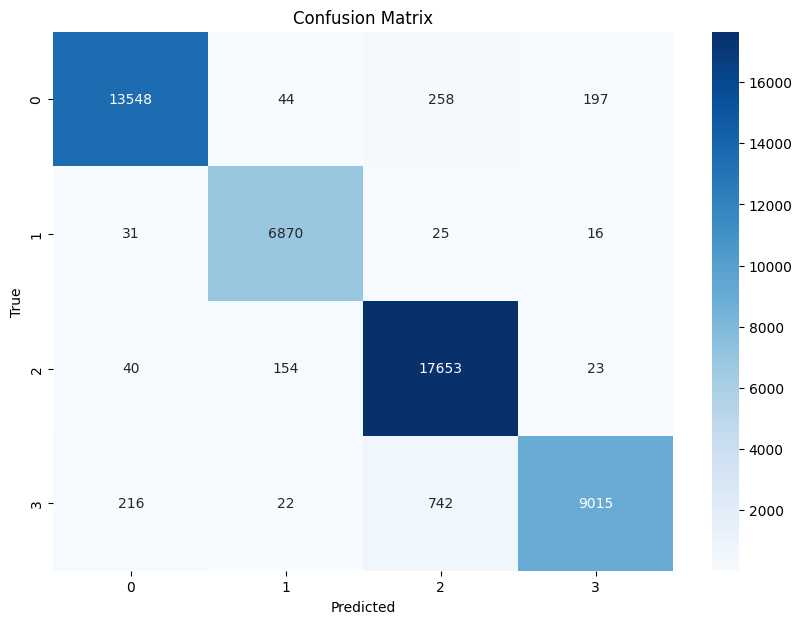

In [60]:
# Confusion matrix for Training Data
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [61]:
# Accuracy, Precision, Recall, F1 Score for Testing Data
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred))

10/94 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
              precision    recall  f1-score   support

           0       0.82      0.66      0.73       750
           1       0.70      0.54      0.61       750
           2       0.59      0.83      0.69       750
           3       0.78      0.78      0.78       750

    accuracy                           0.71      3000
   macro avg       0.72      0.71      0.70      3000
weighted avg       0.72      0.71      0.70      3000



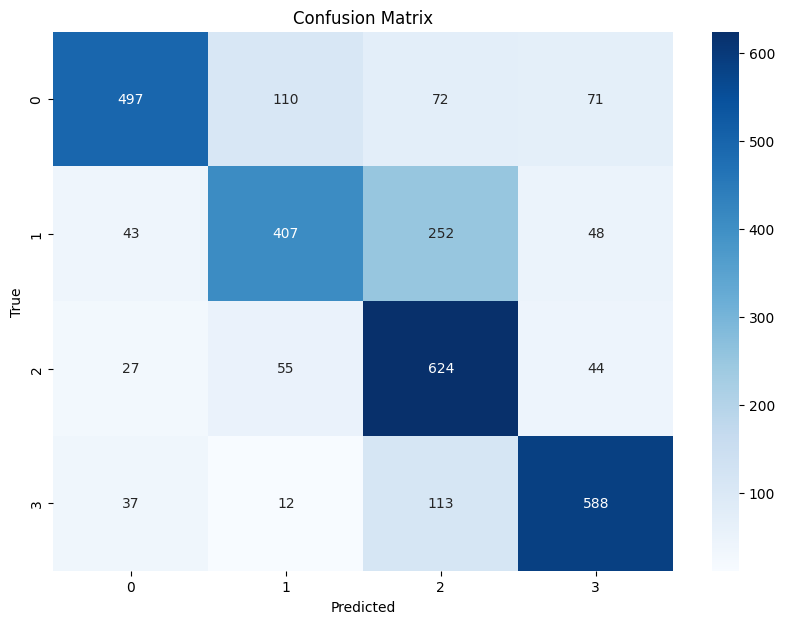

In [62]:
# Confusion matrix for Testing Data
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()